In [147]:
from utils.data_loader import *
from utils.null_handler import *
from utils.model_tuning_utils import *
from utils.analysis_helper import *
from utils.stability_analysis import *
from sys import getsizeof
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
from sys import getsizeof

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *

import warnings
warnings.filterwarnings('ignore')

SEED=10

In [148]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment
    clear_output()

### Loading ACSEmployment data

### TODO: Modify ACSDataLoader to load without nulls 

In [156]:
config = {
    'state': ["NY"],
    'year': '2018',
    'task': ACSEmployment
}

In [157]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [158]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [71]:
y_data

array([0, 1, 0, ..., 0, 0, 1])

#### Checking if there are nulls in the dataset

In [72]:
X_data.isnull().sum()

AGEP             0
SCHL          9028
MAR              0
RELP             0
DIS              0
ESP         203843
CIT              0
MIG           2932
MIL          57794
ANC              0
NATIVITY         0
DEAR             0
DEYE             0
DREM         15202
SEX              0
RAC1P            0
dtype: int64

### Preprocessing: 
#### The ACSEmployment datasheet clearly mentions that nulls are themselves a special category, ie. all the nulls correspond to the "Not Applicable" scenario

In [73]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
handle_nulls = {
'special': ['SCHL','MIG', 'MIL', 'DREM', 'ESP'],
}

for how_to in handle_nulls.keys():
    X_data = handle_df_nulls(X_data, how_to, handle_nulls[how_to])

Impute values:  {'SCHL': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0, 'ESP': 0}


#### Rechecking if there are nulls -- if the null_handler has run correctly, there should not be

In [74]:
X_data.isnull().sum()

AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Simulating nulls: Optional values are missing

In [75]:
# frac of rows that satisfy the condition --- this is also a hyperparameter, find the correct setting?
special_values = [2, 3, 4]
condition_col='MAR'
target_col='MAR'
fraction=0.05
corrupted_data_MAR = nulls_simulator(X_data, target_col, condition_col, special_values, fraction)

In [76]:
corrupted_data_MAR

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
8,77,22.0,2.0,0,2,0.0,1,1.0,2.0,4,1,2,2,2.0,1,1
10,45,17.0,3.0,0,1,0.0,1,3.0,4.0,3,1,2,2,1.0,2,1
13,42,21.0,3.0,0,2,0.0,1,3.0,4.0,1,1,2,2,2.0,1,1
15,58,19.0,3.0,0,1,0.0,4,1.0,4.0,1,2,2,2,2.0,1,1
19,35,16.0,3.0,2,2,0.0,1,1.0,4.0,1,1,2,2,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261891,57,20.0,1.0,0,2,0.0,1,1.0,4.0,2,1,2,2,2.0,2,1
261892,59,21.0,1.0,1,2,0.0,3,1.0,4.0,1,1,2,2,2.0,1,1
261893,66,21.0,1.0,0,2,0.0,1,1.0,4.0,1,1,2,2,2.0,1,1
261894,59,18.0,1.0,1,1,0.0,1,1.0,4.0,1,1,2,2,2.0,2,1


In [79]:
def impute_with_all_techniques(corrupted_data, target_column, column_type):
    if column_type == "categorical":
        how_to_list = ["drop-rows", "impute-by-mode", "impute-by-mode-trimmed"]
    elif column_type == "numerical":
        how_to_list = ["drop-rows", "impute-by-mean", "impute-by-mean-trimmed", "impute-by-median", "impute-by-median-trimmed"]
    else:
        raise ValueError("Incorrect input column_type. It must be in ('categorical', 'numerical')")

    imputed_data_dict = dict()
    for how_to in how_to_list:
        print("\n" * 4, "#" * 15, f" Impute {target_column} column with {how_to} technique ", "#" * 15)
        imputed_data = handle_df_nulls(corrupted_data, how_to, column_names=[target_column])
        imputed_data_dict[how_to] = imputed_data
        imputed_nulls_analysis(imputed_data, corrupted_data, target_col=target_column)

    return imputed_data_dict





 ###############  Impute MAR column with drop-rows technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  1994
Number of nulls in MAR column in the imputed dataframe:  0


<Figure size 1200x1200 with 0 Axes>

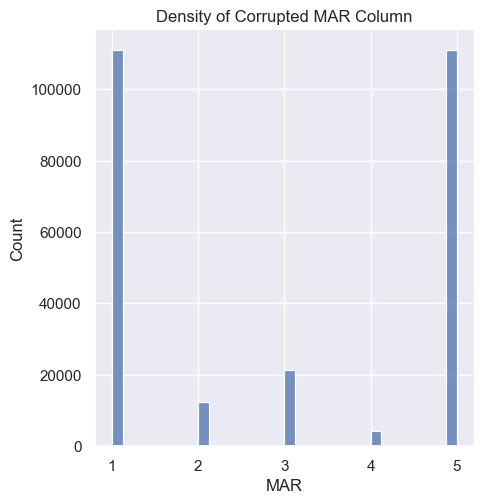

<Figure size 1200x1200 with 0 Axes>

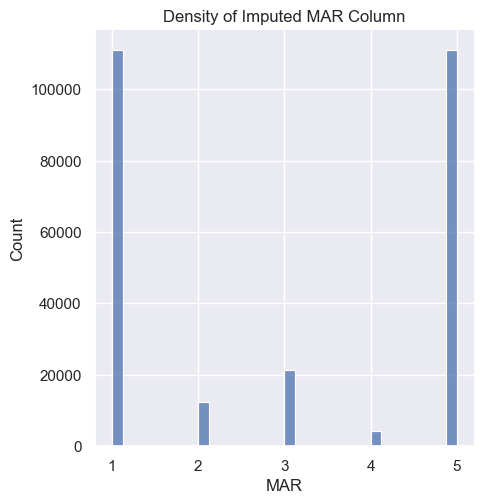





 ###############  Impute MAR column with impute-by-mode technique  ###############
Impute values:  {'MAR': 1.0}
Number of nulls in MAR column in the corrupted dataframe:  1994
Number of nulls in MAR column in the imputed dataframe:  0


<Figure size 1200x1200 with 0 Axes>

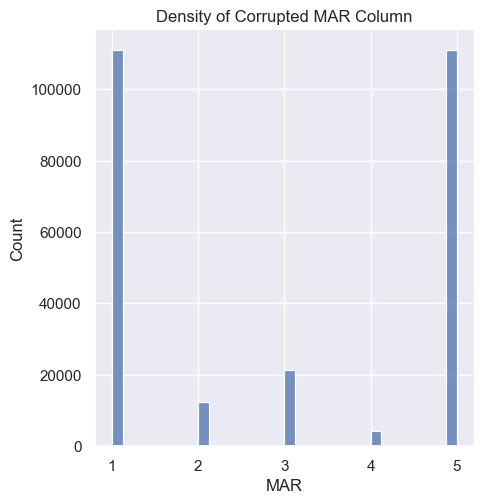

<Figure size 1200x1200 with 0 Axes>

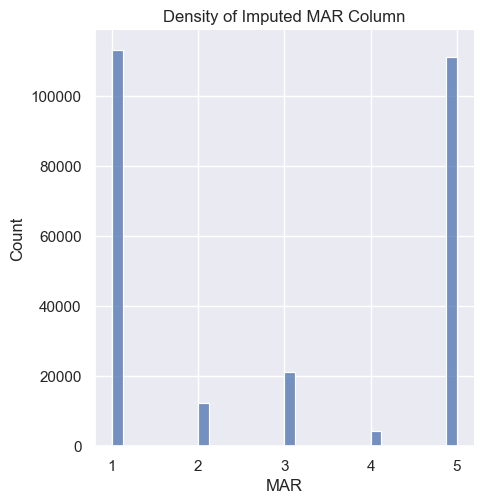





 ###############  Impute MAR column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MAR': 1.0}
Number of nulls in MAR column in the corrupted dataframe:  1994
Number of nulls in MAR column in the imputed dataframe:  0


<Figure size 1200x1200 with 0 Axes>

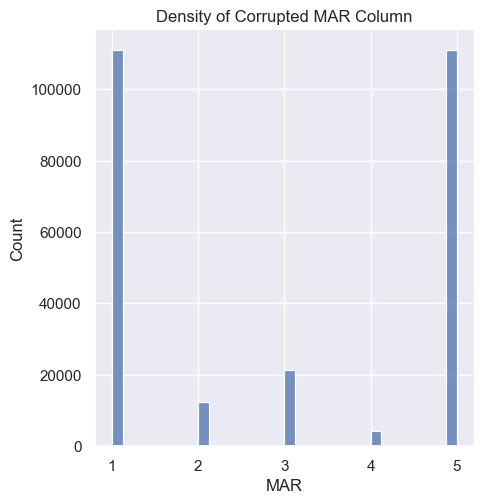

<Figure size 1200x1200 with 0 Axes>

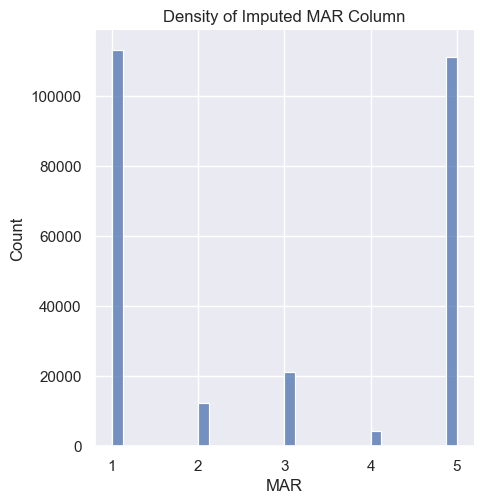

In [80]:
imputed_data_dict_MAR = impute_with_all_techniques(corrupted_data_MAR, target_column="MAR", column_type="categorical")

In [81]:
imputed_data_dict_MAR.keys()

dict_keys(['drop-rows', 'impute-by-mode', 'impute-by-mode-trimmed'])

In [82]:
X_imputed = imputed_data_dict_MAR['impute-by-mode']
# Also dropping rows from the label
y_data_imputed = y_data[X_imputed.index]

In [113]:
X_imputed = X_imputed.drop(columns=['MAR'])

### Creating train-test-validation split

In [114]:
X_train_, X_test, y_train_, y_test = train_test_split(X_imputed, y_data, test_size=0.2, random_state=SEED)
X_train_.shape, X_test.shape

((209516, 15), (52380, 15))

In [115]:
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25, random_state=SEED)
X_train.shape, X_val.shape

((157137, 15), (52379, 15))

In [116]:
# For computing fairness-related metrics
val_groups = load_groups_of_interest('groups.json', X_val)
test_groups = load_groups_of_interest('groups.json', X_test)

val_groups

{'Race': {'values': array([1, 1, 1, ..., 1, 1, 1]),
  'advantaged': 1,
  'disadvantaged': 2},
 'Sex': {'values': array([1, 2, 2, ..., 2, 1, 2], dtype=int8),
  'advantaged': 1,
  'disadvantaged': 2},
 'Race_Sex': {'values': array(['1_1', '1_2', '1_2', ..., '1_2', '1_1', '1_2'], dtype='<U3'),
  'advantaged': '1_1',
  'disadvantaged': '2_2'}}

### Other data pre-processing (making dummies, scaling etc)

In [117]:
X_data.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
      dtype='object')

In [118]:
def make_feature_df(data, categorical_columns, numerical_columns):
    feature_df = pd.get_dummies(data[categorical_columns], columns=categorical_columns)
    for col in numerical_columns:
        feature_df[col] = data[col]
    return feature_df

In [121]:
categorical_col = ['MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
categorical_col = ['RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
numerical_col = ['AGEP', 'SCHL']

In [122]:
X_train_features = make_feature_df(X_train, categorical_col, numerical_col)
X_val_features = make_feature_df(X_val, categorical_col, numerical_col)
X_test_features = make_feature_df(X_test, categorical_col, numerical_col)

In [123]:
X_train_features.shape, X_train.shape

((157137, 69), (157137, 15))

In [124]:
X_train_features

,RELP_0,RELP_1,RELP_2,RELP_3,RELP_4,RELP_5,RELP_6,RELP_7,RELP_8,RELP_9,...,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,AGEP,SCHL
168778,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,9.0
125634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,46,16.0
73502,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,19,1.0
29297,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,33,16.0
204676,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,73,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162912,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,66,12.0
178470,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,85,19.0
66963,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,1.0
251194,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,68,17.0


In [125]:
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)
X_test_features = scaler.transform(X_test_features)

In [126]:
X_train_features

array([[-0.77385677, -0.49178852,  1.68578958, ..., -0.16215625,
        -1.11406832, -0.91057382],
       [-0.77385677, -0.49178852, -0.59319384, ..., -0.16215625,
         0.29856361,  0.1691511 ],
       [-0.77385677, -0.49178852,  1.68578958, ..., -0.16215625,
        -0.85722615, -2.14454517],
       ...,
       [-0.77385677, -0.49178852, -0.59319384, ..., -0.16215625,
        -1.5421386 , -2.14454517],
       [-0.77385677,  2.03339437, -0.59319384, ..., -0.16215625,
         1.24031823,  0.32339752],
       [ 1.29222879, -0.49178852, -0.59319384, ..., -0.16215625,
         0.34137064,  0.78613678]])

### Hyperparameter tuning: Finding the best model for this dataset

In [127]:
n_folds = 3
samples_per_fold = len(y_val)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [128]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True],
            "max_depth": [5,10,20],
            "n_estimators": [30,50,100],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [5,10,20],
            "max_features": [0.6],
            "criterion": ["gini"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [50,100,200],
            'max_depth': [5,10,20],
            'objective':  ['binary:logistic'],
        }
    }
]

In [129]:
tree_model = RandomForestClassifier(bootstrap=True, max_depth=30, max_features=0.6, n_estimators=100)
tree_model.fit(X_train_features, y_train)

print("Train acc:", tree_model.score(X_train_features, y_train))
print("Val acc:", tree_model.score(X_val_features, y_val))

y_pred = tree_model.predict(X_val_features)
print(confusion_matrix(y_val, y_pred))

Train acc: 0.7645684975530906
Val acc: 0.5302124897382539
[[22418  6590]
 [18017  5354]]


In [130]:
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=40, max_features=0.6)
tree_model.fit(X_train_features, y_train)

print("Train acc:", tree_model.score(X_train_features, y_train))
print("Val acc:", tree_model.score(X_val_features, y_val))

y_pred = tree_model.predict(X_val_features)
print(confusion_matrix(y_val, y_pred))

Train acc: 0.7571164016113328
Val acc: 0.5204375799461616
[[19911  9097]
 [16022  7349]]


In [131]:
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train_features, y_train)

print("Train acc:", lr.score(X_train_features, y_train))
print("Val acc:", lr.score(X_val_features, y_val))

y_pred = lr.predict(X_val_features)
print(confusion_matrix(y_val, y_pred))

Train acc: 0.5574944157009488
Val acc: 0.5539433742530403
[[28975    33]
 [23331    40]]


### Quantifying uncertainty using posterior predictive distribution

In [132]:
base_model = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=0.6)
n_estimators = 50
boostrap_size = int(0.5*X_train_features.shape[0])

___, uq_results = UQ_by_boostrap(X_train_features, y_train, X_val_features, y_val, base_model, n_estimators,
               boostrap_size, with_replacement=True, verbose=True)

0
Train acc: 0.5664647184604419
Val acc: 0.5497814009431261
1
Train acc: 0.5739995927095001
Val acc: 0.5493422936673095
2
Train acc: 0.5693666632725791
Val acc: 0.5487504534259914
3
Train acc: 0.5630663883514917
Val acc: 0.5495141182534985
4
Train acc: 0.5674702168821912
Val acc: 0.549361385287997
5
Train acc: 0.5699648711943794
Val acc: 0.5494950266328109
6
Train acc: 0.565471947866816
Val acc: 0.5490750109776819
7
Train acc: 0.5665665410854291
Val acc: 0.548826819908742
8
Train acc: 0.5646446390387945
Val acc: 0.551576013287768
9
Train acc: 0.5693793911007026
Val acc: 0.5506405238740717
10
Train acc: 0.5678011404133999
Val acc: 0.5470512991847878
11
Train acc: 0.565408308726199
Val acc: 0.5489222780121804
12
Train acc: 0.5645809998981773
Val acc: 0.5517669294946448
13
Train acc: 0.5694303024131963
Val acc: 0.5475285897019798
14
Train acc: 0.5690993788819876
Val acc: 0.5490177361156189
15
Train acc: 0.5631809388046024
Val acc: 0.5507741652188854
16
Train acc: 0.567648406475919
Val acc

In [133]:
def plot_generic(x, y, xlabel, ylabel, plot_title):
    plt.figure(figsize=(20,10))
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(plot_title)
    plt.show()

In [134]:
results = pd.DataFrame(uq_results).transpose()
means = results.mean().values
stds = results.std().values
iqr = sp.stats.iqr(results,axis=0)

y_preds = np.array([int(x<0.5) for x in results.mean().values])
acc = [y_preds[i] == y_val[i] for i in range(len(y_val))]
np.mean(np.array(acc))

0.5531606178048455

In [146]:
results

,0,1,2,3,4,5,6,7,8,9,...,52369,52370,52371,52372,52373,52374,52375,52376,52377,52378
0,0.573672,0.563924,0.573672,0.559920,0.563924,0.517986,0.545627,0.545627,0.559920,0.487805,...,0.524978,0.559920,0.593631,0.563924,0.000000,0.524978,0.563924,0.563924,0.563924,0.563924
1,0.551069,0.561221,0.551069,0.518879,0.561566,0.551069,0.561566,0.561566,0.561566,0.549227,...,0.561566,0.550212,0.549227,0.561566,0.561566,0.571862,0.561221,0.561566,0.549227,0.561566
2,0.560703,0.551119,0.570093,0.460177,0.354839,0.570093,0.540601,0.560703,0.560703,0.551119,...,0.555971,0.550962,0.566474,0.560703,0.540601,0.555971,0.570093,0.570093,0.566474,0.570093
3,0.558942,0.558942,0.558942,0.595993,0.595993,0.549231,0.558942,0.558942,0.558942,0.558942,...,0.558942,0.558942,0.557477,0.558942,0.558942,0.558942,0.558942,0.558942,0.558942,0.558942
4,0.561655,0.561655,0.561655,0.388889,0.972973,0.553141,0.555773,0.555773,0.555773,0.555773,...,0.555773,0.555773,0.561509,0.555773,0.561509,0.561655,0.561655,0.555773,0.555773,0.555773
5,0.564844,0.539528,0.550182,0.379630,0.456897,0.511222,0.473262,0.564844,0.546411,0.506988,...,0.550182,0.560390,0.577946,0.539528,0.111111,0.589645,0.550182,0.539528,0.564844,0.550182
6,0.568041,0.563306,0.563306,0.322581,0.563306,0.517192,0.556852,0.556852,0.568041,0.563306,...,0.542417,0.568041,0.542417,0.568041,0.568041,0.568041,0.563306,0.563306,0.568041,0.563306
7,0.543639,0.567441,0.570617,0.543639,0.571527,0.543639,0.543639,0.534351,0.543639,0.571527,...,0.543639,0.543639,0.572830,0.571527,0.390625,0.543639,0.567441,0.571527,0.572830,0.571527
8,0.557526,0.557526,0.557526,0.518371,0.557526,0.535641,0.557526,0.557526,0.557526,0.557526,...,0.557526,0.557526,0.574059,0.557526,0.000000,0.557526,0.557526,0.557526,0.574059,0.557526
9,0.614372,0.538676,0.556452,0.541896,0.556452,0.556452,0.556452,0.556452,0.556452,0.564089,...,0.564089,0.579811,0.564089,0.556452,0.556452,0.538676,0.556452,0.556452,0.564089,0.556452


In [135]:
# Comparing the ensemble we constructed with an sklearn ensemble
tree_model = RandomForestClassifier(bootstrap=True, max_depth=10, max_features=0.6, n_estimators=n_estimators)
tree_model.fit(X_train_features, y_train)

print("Train acc:", tree_model.score(X_train_features, y_train))
print("Val acc:", tree_model.score(X_val_features, y_val))

Train acc: 0.5646983205737668
Val acc: 0.5536188167013498


In [136]:
per_sample_predictions = {}
label_stability = []
per_sample_accuracy = []
for sample in range(len(y_val)):
    per_sample_predictions[sample] =  [int(x<0.5) for x in results[sample].values]
    label_stability.append(compute_label_stability(per_sample_predictions[sample]))
    
    if y_val[sample] == 1:
        acc = np.mean(per_sample_predictions[sample])
    elif y_val[sample] == 0:
        acc = 1 - np.mean(per_sample_predictions[sample])
    per_sample_accuracy.append(acc)

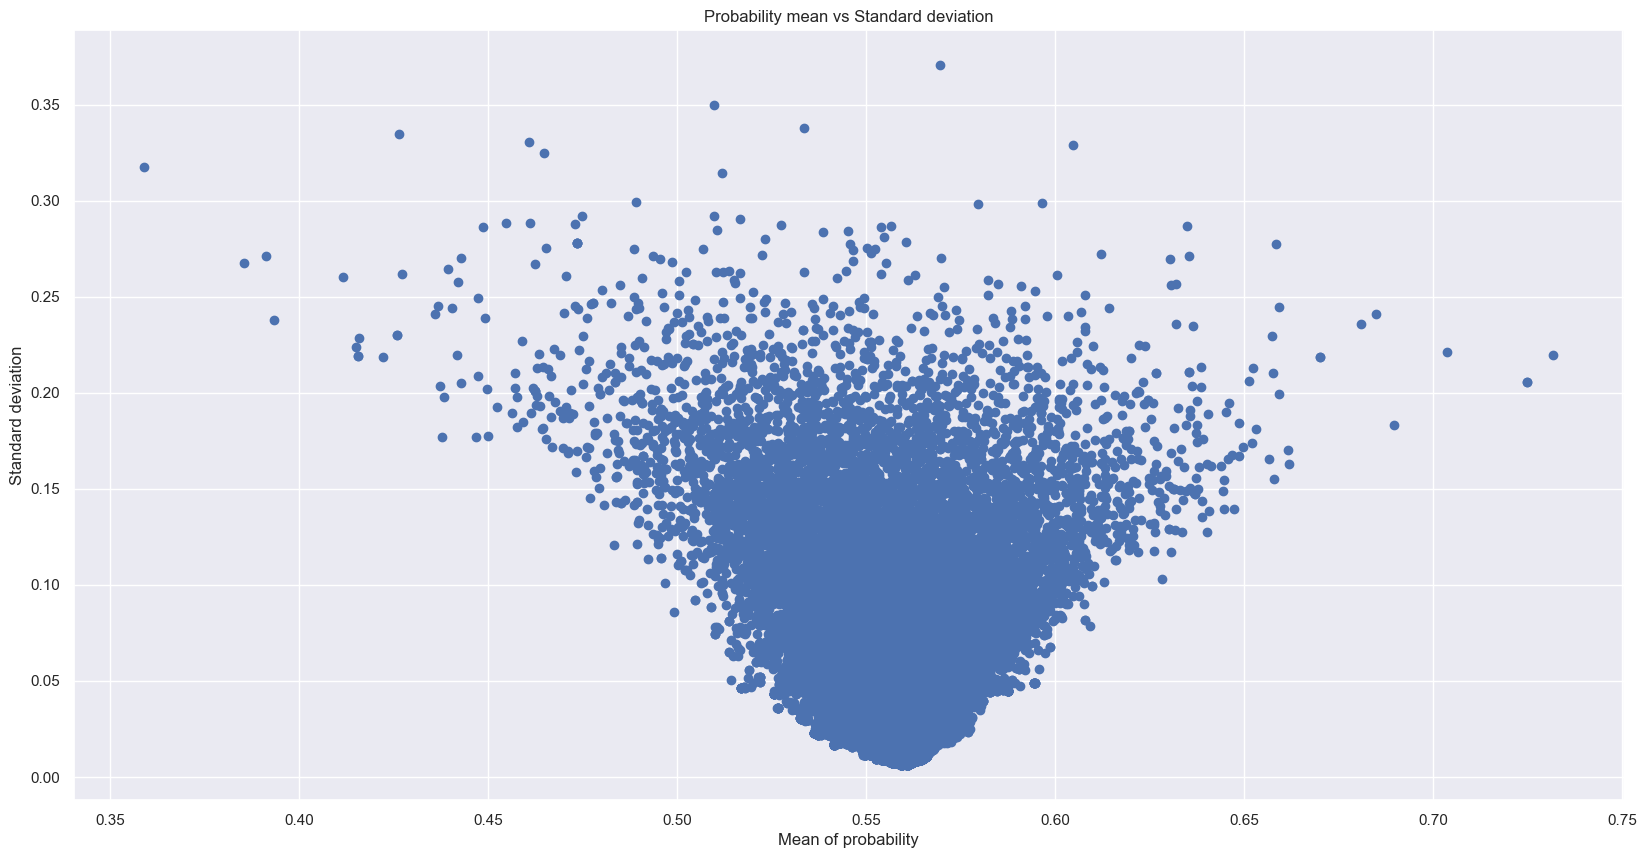

In [137]:
plot_generic(means, stds, "Mean of probability", "Standard deviation", "Probability mean vs Standard deviation")

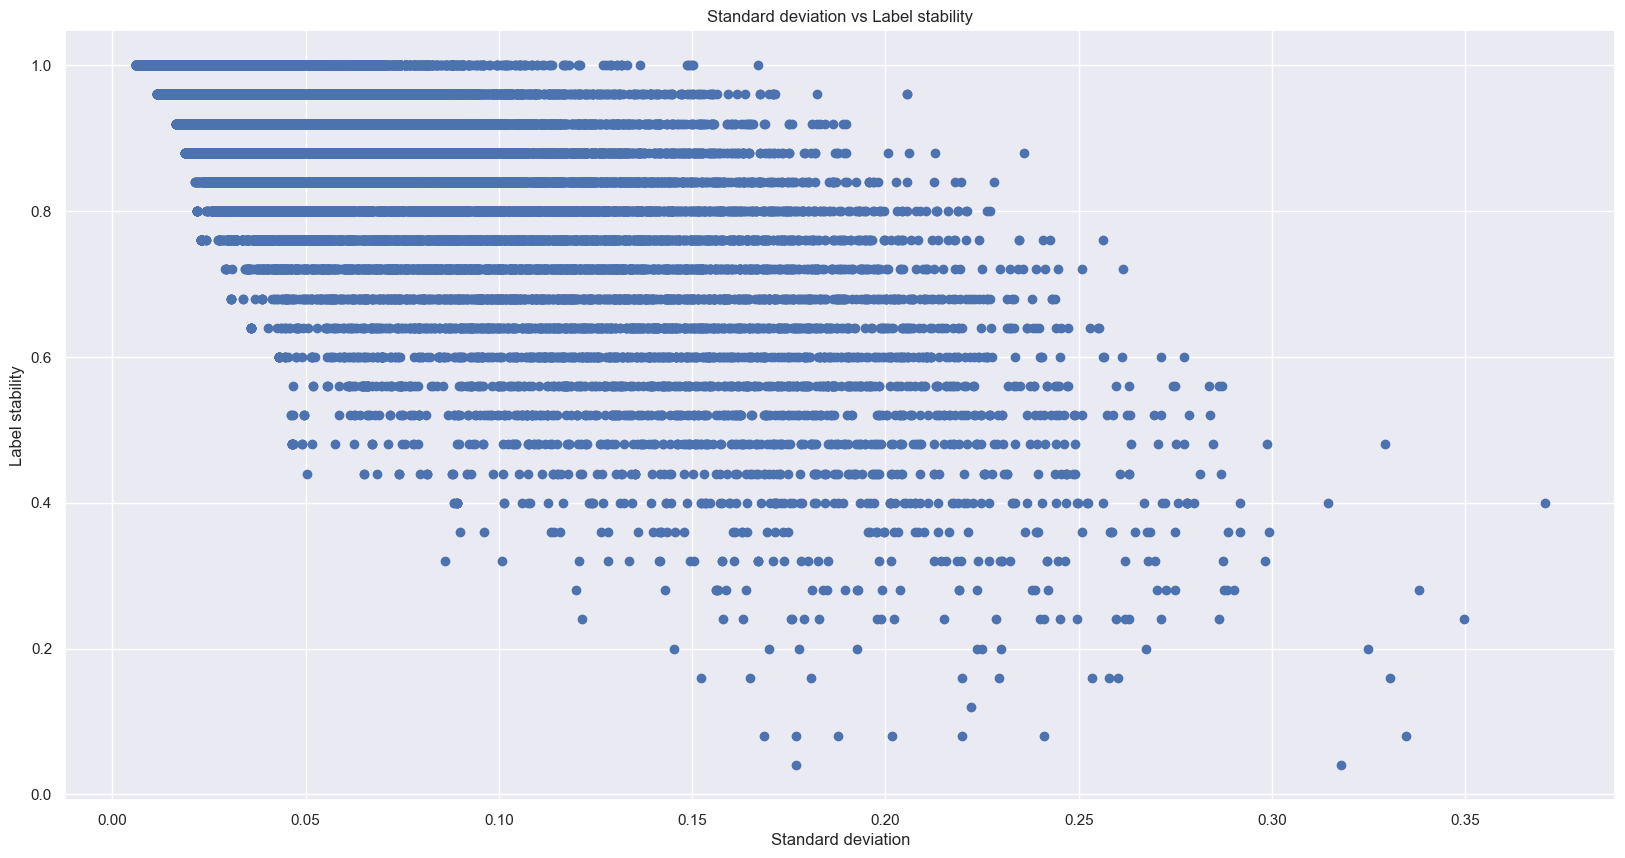

In [138]:
plot_generic(stds, label_stability, "Standard deviation", "Label stability", "Standard deviation vs Label stability")

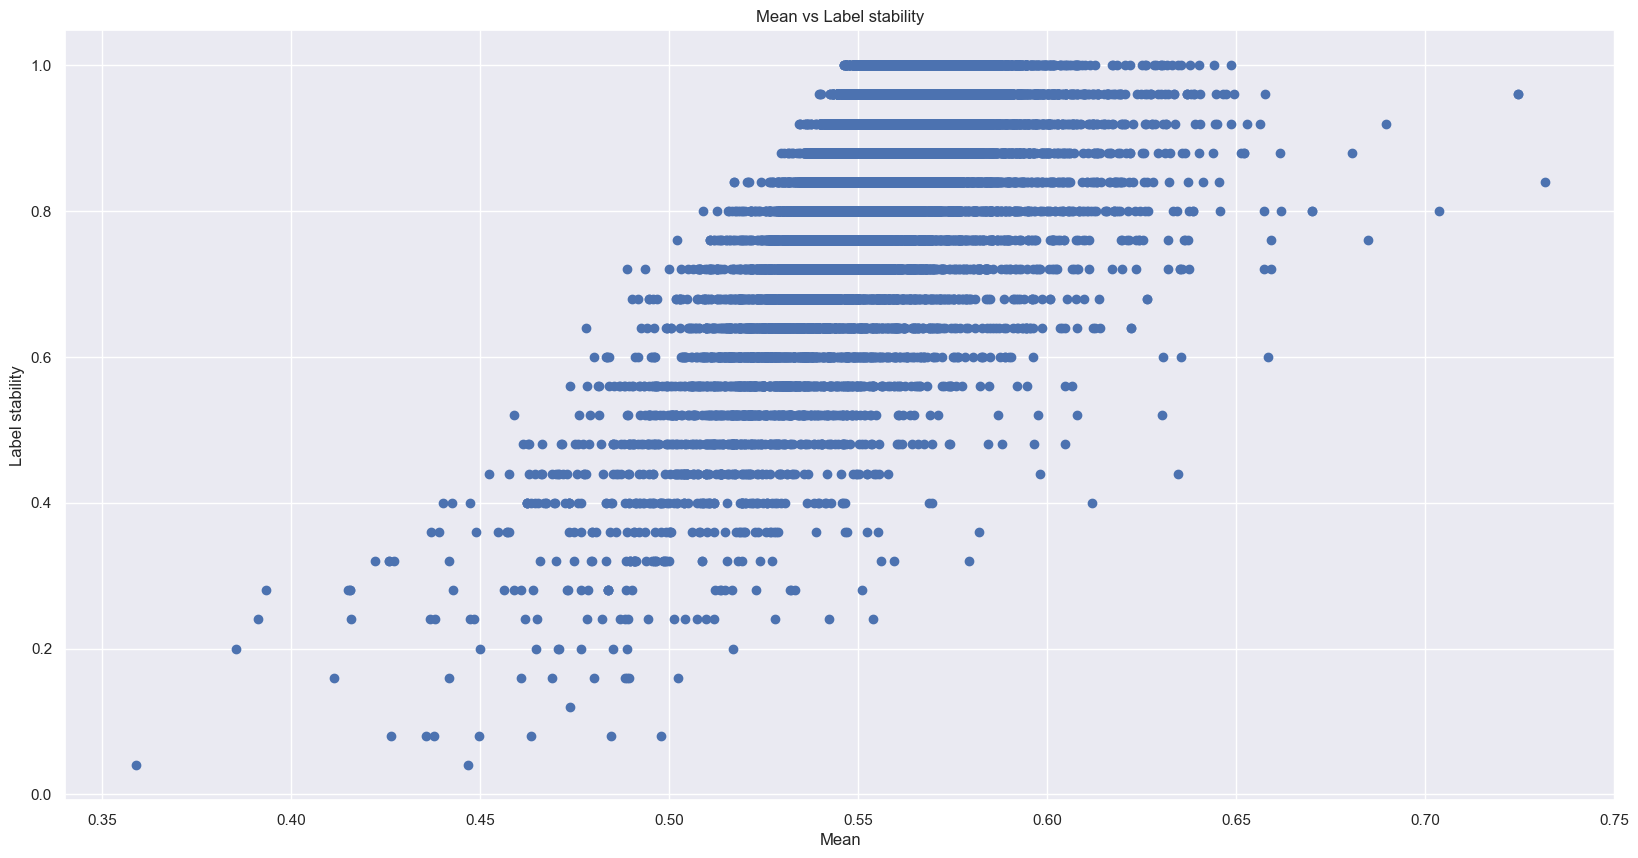

In [139]:
plot_generic(means, label_stability, "Mean", "Label stability", "Mean vs Label stability")

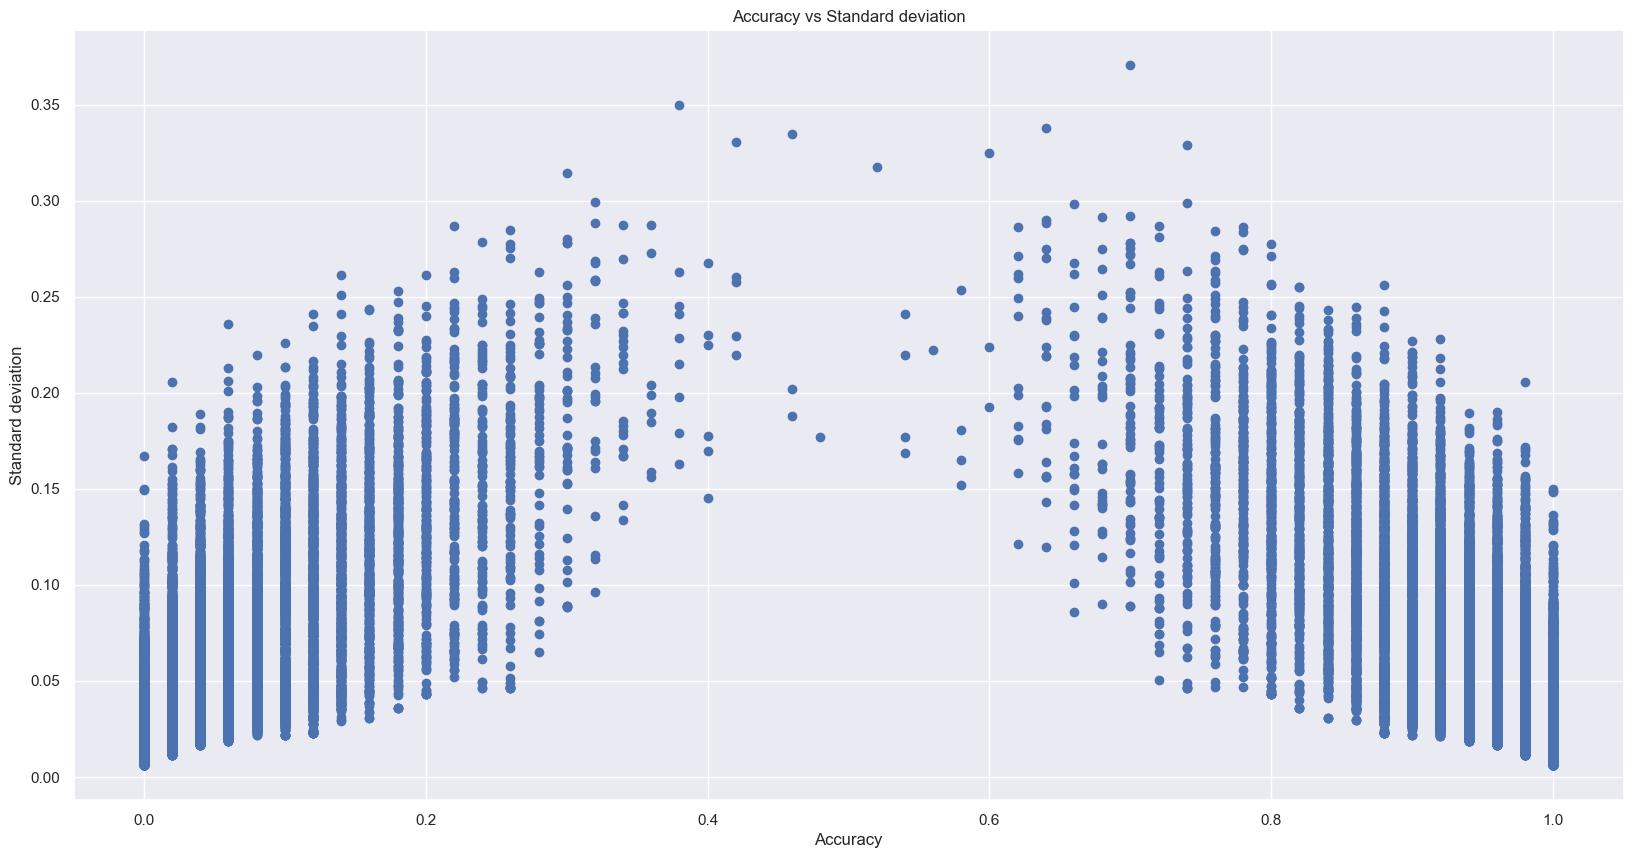

In [140]:
plot_generic(per_sample_accuracy, stds, "Accuracy", "Standard deviation", "Accuracy vs Standard deviation")

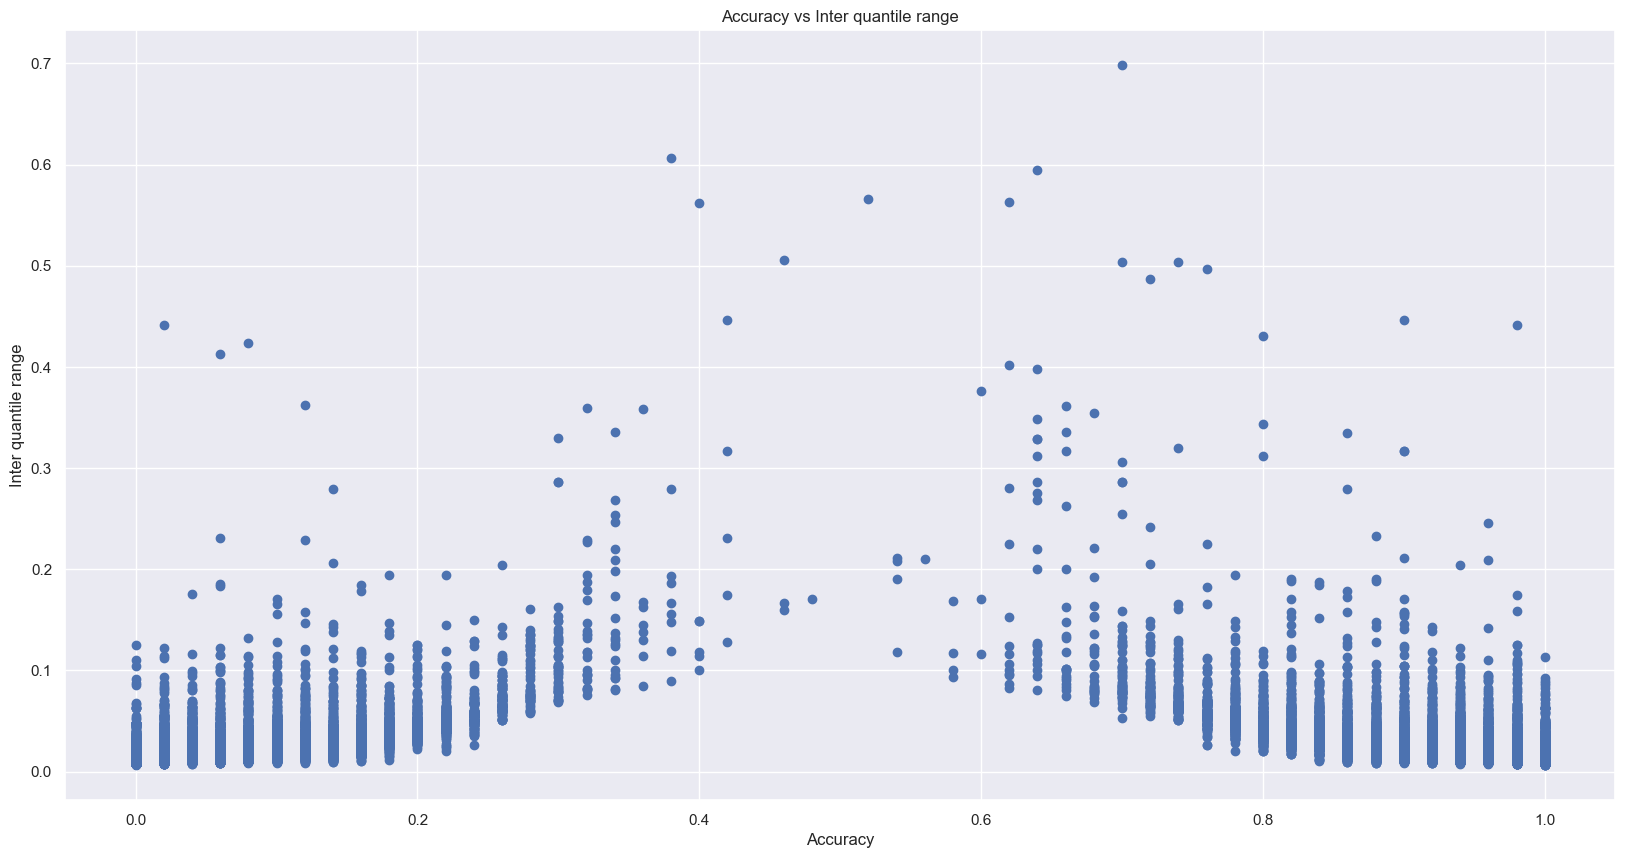

In [141]:
plot_generic(per_sample_accuracy, iqr, "Accuracy", "Inter quantile range", "Accuracy vs Inter quantile range")

In [142]:
fairness_metrics = {}
metrics = ['Accuracy', 'Disparate_Impact', 'Equal_Opportunity', 'Statistical_Parity_Difference']
for metric in metrics:
            fairness_metrics[metric]= compute_metric(y_preds, y_val, val_groups, metric)

fairness_metrics

{'Accuracy':               Race       Sex  Race_Sex
 adv       0.552163  0.549665  0.549129
 disadv    0.559992  0.556555  0.563332
 Accuracy -0.007829 -0.006890 -0.014203,
 'Disparate_Impact':                       Race       Sex  Race_Sex
 adv               0.004299  0.006278  0.004507
 disadv            0.006459  0.005719  0.005325
 Disparate_Impact  1.502653  0.910981  1.181489,
 'Equal_Opportunity':                        Race       Sex  Race_Sex
 adv                0.004198  0.005524  0.004117
 disadv             0.007996  0.006449  0.006957
 Equal_Opportunity -0.003799 -0.000925 -0.002839,
 'Statistical_Parity_Difference':                                   Race       Sex  Race_Sex
 adv                            0.00961  0.013982  0.010014
 disadv                         0.01466  0.012898  0.012174
 Statistical_Parity_Difference -0.00505  0.001085 -0.002159}

In [143]:
y_preds = np.array([int(x<0.5) for x in results.mean().values])
accuracy = np.mean(np.array([y_preds[i] == y_val[i] for i in range(len(y_val))]))
accuracy

0.5531606178048455

In [144]:
metrics_to_report={}
metrics_to_report['Accuracy'] = accuracy
metrics_to_report['Label_stability'] = [np.mean(label_stability)]
metrics_to_report['SD'] = [np.mean(stds)]
metrics_to_report['IQR'] = [np.mean(iqr)]
metrics_to_report['SPD_Race'] = [fairness_metrics['Statistical_Parity_Difference']['Race'].loc['Statistical_Parity_Difference']]
metrics_to_report['SPD_Sex'] = [fairness_metrics['Statistical_Parity_Difference']['Sex'].loc['Statistical_Parity_Difference']]
metrics_to_report['SPD_Race_Sex'] = [fairness_metrics['Statistical_Parity_Difference']['Race_Sex'].loc['Statistical_Parity_Difference']]
metrics_to_report['EO_Race'] = [fairness_metrics['Equal_Opportunity']['Race'].loc['Equal_Opportunity']]
metrics_to_report['EO_Sex'] = [fairness_metrics['Equal_Opportunity']['Sex'].loc['Equal_Opportunity']]
metrics_to_report['EO_Race_Sex'] = [fairness_metrics['Equal_Opportunity']['Race_Sex'].loc['Equal_Opportunity']]



pd.DataFrame(metrics_to_report)

,Accuracy,Label_stability,SD,IQR,SPD_Race,SPD_Sex,SPD_Race_Sex,EO_Race,EO_Sex,EO_Race_Sex
0,0.553161,0.913836,0.045497,0.019854,-0.00505,0.001085,-0.002159,-0.003799,-0.000925,-0.002839


In [145]:
import pickle

f = open("TX_2016_optional_drop_column.pkl","wb")
pickle.dump(metrics_to_report,f)
f.close()